# All the parameters that need to be changed

In [1]:
# Minnesota
state_ab = "mn"

## Data
1. Download all the data in directory "mn_data"
2. Eextract them all

In [2]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_adopted_2022/c2022.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_adopted_2022/l2022-sen-shp.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2022/l2022_hse.shp".format(data_folder, state_ab)
county_data = "./{}{}_cvap_2022_cnty/{}_cvap_2022_cnty.shp".format(data_folder, state_ab, state_ab)

## Parameters that needs to be manually checked

### base vest data
start_col = 5\
vest_base_data = vest20\
year = '20'

### district data
district column name of cong_df, send, hdist when calling add_dist()

# Program starts

In [3]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph
import os

maup.progress.enabled = True

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length, snap_precision = snap_precision)

    if maup.doctor(df) == False:
        raise Exception('maup.doctor failed')
    
    return df

In [6]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [7]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [8]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [9]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [10]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [11]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

## Read the census data

In [12]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [13]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [14]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [15]:
maup.doctor(population_df)

100%|████████████████████████████████████████████████████████████| 198705/198705 [02:10<00:00, 1517.01it/s]


True

In [16]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
               'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
               'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
               'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [17]:
population_df.rename(columns=rename_dict, inplace = True)

In [18]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['NH_WHITE'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['NH_BLACK'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['NH_AMIN'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['NH_ASIAN'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['NH_NHPI'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['NH_OTHER'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['NH_2MORE'], 1)

Make sure that the County shapefile is clean:

In [19]:
maup.doctor(county_df)

100%|████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 1160.71it/s]


True

# Read the base vest data
Now using it as a "base precinct", but it could be vest 18 or vest 16 if vest 20 is not working

### Check if vest 20 can be used as base

In [20]:
vest20 = gpd.read_file(vest20_data)

In [21]:
vest20.columns

Index(['VTDID', 'PCTNAME', 'COUNTYNAME', 'COUNTYFIPS', 'G20PREDBID',
       'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PREAFUE', 'G20PREPLAR',
       'G20PRESKEN', 'G20PREIWES', 'G20PREIPIE', 'G20PREOWRI', 'G20USSDSMI',
       'G20USSRLEW', 'G20USSMOCO', 'G20USSCSTE', 'G20USSOWRI', 'geometry'],
      dtype='object')

## Parameters that need to be checked

In [22]:
start_col = 4
vest_base_data = vest20
year = '20'

In [23]:
vest_base = add_vest_base(vest20, start_col, year, county = county_df)

100%|████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 1468.05it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|█████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 180.31it/s]


Identifying overlaps...


100%|██████████████████████████████████████████████████████████████| 17168/17168 [00:06<00:00, 2670.56it/s]


Resolving overlaps and filling gaps...


Gaps to fill in region 3: 100%|████████████████████████████████████████████| 20/20 [00:00<00:00, 39.01it/s]
Gaps to simplify in region 4: 211it [00:04, 46.72it/s]                                                     
Gaps to fill in region 12: 100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 35.61it/s]
Gaps to simplify in region 13: 348it [00:04, 85.14it/s]                                                    
Gaps to simplify in region 18:  79%|█████████████████████████████        | 327/416 [00:13<00:02, 39.38it/s]

Found a component of the region at index 18 that does not intersect any geometry assigned to that region.


Gaps to simplify in region 18:  90%|█████████████████████████████████▎   | 374/416 [00:14<00:01, 33.03it/s]

Found a component of the region at index 18 that does not intersect any geometry assigned to that region.


Gaps to simplify in region 19:  44%|████████████████▎                    | 107/242 [00:02<00:02, 61.33it/s]

Found a component of the region at index 19 that does not intersect any geometry assigned to that region.


Gaps to fill in region 22: 100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 53.25it/s]
Gaps to simplify in region 23: 161it [00:03, 46.09it/s]                                                    
Gaps to fill in region 33: 100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 64.85it/s]
Gaps to simplify in region 34: 57it [00:00, 107.34it/s]                                                    
Gaps to fill in region 69: 100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 30.99it/s]
Gaps to simplify in region 70: 78it [00:00, 95.57it/s]                                                     
Gaps to fill in region 86: 100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 30.61it/s]


Let's look at the border lengths.  If there's a clear reasonable cutoff for switching rook adjacencies to queen, we use that.  Otherwise, we can use 30.5 m (which is approximately 100 ft).  This is not a magic number, just a reasonable one.

In [24]:
borders = check_small_boundary_lengths(vest_base)
print(borders[:6000])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

It's not clear what the cutoff should be here; let's use 30.5.

In [25]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|████████████████████████████████████████████████████████████████| 4936/4936 [00:01<00:00, 3258.83it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|████████████████████████████████████████████████████████████████| 4110/4110 [00:02<00:00, 1468.06it/s]


In [26]:
maup.doctor(vest_base)

100%|████████████████████████████████████████████████████████████████| 4110/4110 [00:03<00:00, 1315.91it/s]


True

### If it is true for maup doctor, we will use it as the base vest data.

In [27]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|█████████████████████████████████████████████████████████████████| 4110/4110 [00:18<00:00, 226.73it/s]


In [28]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [29]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [30]:
election_df = gpd.GeoDataFrame(vest_base)

In [31]:
election_df.columns

Index(['COUNTYFIPS', 'COUNTYNAME', 'PCTNAME', 'PRE20D', 'PRE20O', 'PRE20R',
       'USS20D', 'USS20O', 'USS20R', 'VTDID', 'geometry', 'TOTPOP', 'HISP',
       'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER',
       'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI',
       'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP',
       'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

### Check if the population agrees

In [32]:
check_population(population_df, vest_base)

population agrees


# Add more vest data

In [33]:
vest18 = gpd.read_file(vest18_data)

In [34]:
list(vest18.columns)

['COUNTYNAME',
 'COUNTYFIPS',
 'VTDID',
 'PCTNAME',
 'PCTCODE',
 'SHORTLABEL',
 'MCDNAME',
 'MCDCODE',
 'MCDFIPS',
 'MCDGNIS',
 'CONGDIST',
 'MNSENDIST',
 'MNLEGDIST',
 'CTYCOMDIST',
 'JUDDIST',
 'G18USSRNEW',
 'G18USSDKLO',
 'G18USSMSCH',
 'G18USSGOVE',
 'G18USSOWRI',
 'S18USSRHOU',
 'S18USSDSMI',
 'S18USSMWEL',
 'S18USSUTRO',
 'S18USSOWRI',
 'G18GOVRJOH',
 'G18GOVDWAL',
 'G18GOVMWRI',
 'G18GOVLWEL',
 'G18GOVOWRI',
 'G18SOSRHOW',
 'G18SOSDSIM',
 'G18SOSIDEN',
 'G18SOSOWRI',
 'G18AUDRMYH',
 'G18AUDDBLA',
 'G18AUDMFOR',
 'G18AUDLDOC',
 'G18AUDOWRI',
 'G18ATGRWAR',
 'G18ATGDELL',
 'G18ATGMJOH',
 'G18ATGOWRI',
 'geometry']

In [35]:
# check the result here
start_col = 15
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|████████████████████████████████████████████████████████████████| 4113/4113 [00:02<00:00, 1462.43it/s]


There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|████████████████████████████████████████████████████████████████| 4957/4957 [00:01<00:00, 4274.82it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████| 4110/4110 [00:18<00:00, 218.88it/s]


population agrees


In [36]:
vest16 = gpd.read_file(vest16_data)
vest16.columns

Index(['VTDID', 'PCTNAME', 'PCTCODE', 'SHORTLABEL', 'MCDNAME', 'MCDCODE',
       'MCDFIPS', 'MCDGNIS', 'G16PRERTru', 'G16PREDCli', 'G16PRECCas',
       'G16PREMVac', 'G16PRESKen', 'G16PREGSte', 'G16PREIDeL', 'G16PREIMcM',
       'G16PRELJoh', 'G16PREOth', 'geometry'],
      dtype='object')

In [37]:
start_col = 8
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|█████████████████████████████████████████████████████████████████| 4120/4120 [00:05<00:00, 719.11it/s]


There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|████████████████████████████████████████████████████████████████| 5021/5021 [00:01<00:00, 2997.51it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████| 4110/4110 [00:20<00:00, 202.31it/s]


population agrees


## Add the district data

In [38]:
cong_df = gpd.read_file(cd_data)
cong_df = cong_df.to_crs(cong_df.estimate_utm_crs())
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [39]:
cong_df.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,NH_WHT,HISPANIC_O,NH_DOJ_BLK,...,F_NH18_DO3,F_NH18_DO4,F_NH18_DO5,F_NH18_WHT,F_18_POP,F_DEM_INDE,F_REP_INDE,F_THIRD_IN,DISTRICT_L,geometry
0,1,12430.222656,1,1.0,None,None,713311,587883,51121,27369,...,0.000601,0.002295,0.022386,0.855693,0.770142,0.477860,0.474246,0.047894,1|-0%,"POLYGON ((521223.785 4951253.465, 521495.479 4..."
1,2,1805.995972,2,1.0,None,None,713312,536985,54131,44486,...,0.000441,0.004392,0.030024,0.790203,0.750402,0.494260,0.460461,0.045279,2|0%,"POLYGON ((467671.377 4893765.723, 467511.709 4..."
2,3,515.873108,3,1.0,None,None,713311,509159,37414,67558,...,0.000233,0.003791,0.030805,0.757537,0.769882,0.522974,0.441346,0.035680,3|-0%,"POLYGON ((469417.116 5009807.191, 469434.698 5..."
3,4,333.247986,4,1.0,None,None,713312,443863,52740,79285,...,0.000340,0.003779,0.033634,0.678897,0.770141,0.636964,0.311469,0.051567,4|0%,"POLYGON ((498386.356 4996710.697, 498420.330 4..."
4,5,136.886185,5,1.0,None,None,713312,427555,72377,121980,...,0.000393,0.004791,0.039950,0.653848,0.801732,0.748150,0.201100,0.050750,5|0%,"POLYGON ((479098.152 4996824.609, 479204.312 4..."


In [40]:
set(cong_df['DISTRICT'])

{'1', '2', '3', '4', '5', '6', '7', '8'}

In [41]:
election_df = add_district(cong_df, "CD", election_df, "DISTRICT")

100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.36it/s]


In [42]:
send.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,NH_WHT,HISPANIC_O,NH_DOJ_BLK,...,F_NH18_DO3,F_NH18_DO4,F_NH18_DO5,F_NH18_WHT,F_18_POP,F_DEM_INDE,F_REP_INDE,F_THIRD_IN,DISTRICT_L,geometry
0,1,8599.527344,01,1.0,None,None,85175,75057,3788,1267,...,0.000277,0.002677,0.026662,0.904585,0.763135,0.457220,0.497637,0.045143,01|0%,"POLYGON ((229817.099 5228157.579, 229440.370 5..."
1,2,8808.734375,02,1.0,None,None,85461,59017,1748,595,...,0.000171,0.002957,0.046515,0.745592,0.751910,0.475356,0.474558,0.050086,02|0.34%,"POLYGON ((394762.914 5395196.693, 394762.693 5..."
2,3,14772.773438,03,1.0,None,None,84754,76968,1144,526,...,0.000175,0.002531,0.033038,0.921324,0.811030,0.538565,0.421804,0.039631,03|-0.49%,"POLYGON ((394762.914 5395196.693, 395221.273 5..."
3,4,1340.252563,04,1.0,None,None,85002,71651,3383,3281,...,0.000358,0.002150,0.035057,0.873516,0.755065,0.522808,0.426478,0.050714,04|-0.2%,"POLYGON ((286407.640 5177455.953, 285435.998 5..."
4,5,3758.213867,05,1.0,None,None,85402,77560,3313,383,...,0.000888,0.002020,0.026308,0.926662,0.765099,0.365531,0.592854,0.041615,05|0.27%,"POLYGON ((334160.856 5108147.967, 334163.114 5..."


In [43]:
len(set(send['DISTRICT']))

67

In [44]:
hdist.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,NH_WHT,HISPANIC_O,NH_DOJ_BLK,...,F_NH18_DO3,F_NH18_DO4,F_NH18_DO5,F_NH18_WHT,F_18_POP,F_DEM_INDE,F_REP_INDE,F_THIRD_IN,DISTRICT_L,geometry
0,1,5197.243652,01A,1.0,None,None,42570,38247,1382,275,...,0.000550,0.002933,0.026548,0.918034,0.768922,0.433413,0.521210,0.045377,01A|-0.04%,"POLYGON ((307143.777 5312188.062, 307136.682 5..."
1,2,3402.283936,01B,1.0,None,None,42605,36810,2406,992,...,0.000000,0.002417,0.026777,0.890941,0.757352,0.482788,0.472321,0.044891,01B|0.04%,"POLYGON ((229817.099 5228157.579, 229440.370 5..."
2,3,4535.418457,02A,1.0,None,None,42871,30297,1067,510,...,0.000124,0.002412,0.039549,0.757297,0.754356,0.501386,0.444328,0.054286,02A|0.67%,"POLYGON ((394185.295 5358115.221, 394402.382 5..."
3,4,4273.315918,02B,1.0,None,None,42590,28720,681,85,...,0.000219,0.003509,0.053573,0.733732,0.749448,0.449601,0.504468,0.045931,02B|0.01%,"POLYGON ((393846.889 5319482.248, 393934.129 5..."
4,5,13688.615234,03A,1.0,None,None,42417,37934,611,240,...,0.000170,0.002830,0.032229,0.911208,0.833180,0.521834,0.434363,0.043803,03A|-0.4%,"POLYGON ((394762.914 5395196.693, 395221.273 5..."


In [45]:
len(set(hdist['DISTRICT']))

134

In [46]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|██████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 64.03it/s]


In [47]:
election_df = add_district(hdist, "HDIST", election_df, "DISTRICT")

100%|████████████████████████████████████████████████████████████████████| 134/134 [00:01<00:00, 89.47it/s]


In [48]:
list(election_df.columns)

['2MOREVAP',
 'AMINVAP',
 'ASIANVAP',
 'ATG18D',
 'ATG18O',
 'ATG18R',
 'AUD18D',
 'AUD18O',
 'AUD18R',
 'BVAP',
 'COUNTYFIPS',
 'COUNTYNAME',
 'GOV18D',
 'GOV18O',
 'GOV18R',
 'HISP',
 'HVAP',
 'H_2MORE',
 'H_AMIN',
 'H_ASIAN',
 'H_BLACK',
 'H_NHPI',
 'H_OTHER',
 'H_WHITE',
 'NHPIVAP',
 'NH_2MORE',
 'NH_AMIN',
 'NH_ASIAN',
 'NH_BLACK',
 'NH_NHPI',
 'NH_OTHER',
 'NH_WHITE',
 'OTHERVAP',
 'PCTNAME',
 'PRE16D',
 'PRE16O',
 'PRE16R',
 'PRE20D',
 'PRE20O',
 'PRE20R',
 'SOS18D',
 'SOS18O',
 'SOS18R',
 'TOTPOP',
 'USS18D',
 'USS18O',
 'USS18R',
 'USS20D',
 'USS20O',
 'USS20R',
 'VAP',
 'VTDID',
 'WVAP',
 'geometry',
 'CD',
 'SEND',
 'HDIST']

### Put the base precinct year after the precinct information column

In [49]:
base_columns = {}
if 'COUNTYFIPS' + year not in election_df.columns:
    base_columns = {
        'COUNTYFIPS': 'COUNTYFIPS' + year,
        'COUNTYNAME': 'COUNTYNAME' + year,
        'VTDID': 'VTDID' + year,
        'PCTNAME': 'PCTNAME' + year,
    }
election_df.rename(columns=base_columns, inplace = True)

In [50]:
# reorder the columns
fixed_columns = [
    'COUNTYFIPS' + year,
    'COUNTYNAME' + year,
    'VTDID' + year,
    'PCTNAME' + year,
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [51]:
os.makedirs("./{}".format(state_ab), exist_ok=True)
election_df.to_file("./{}/{}.shp".format(state_ab, state_ab))
election_df.to_file('./{}/{}.geojson'.format(state_ab, state_ab), driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file("./{}/{}.shp".format(state_ab, state_ab), ignore_errors=True)
graph.to_json("./{}/{}.json".format(state_ab, state_ab))

<Axes: >

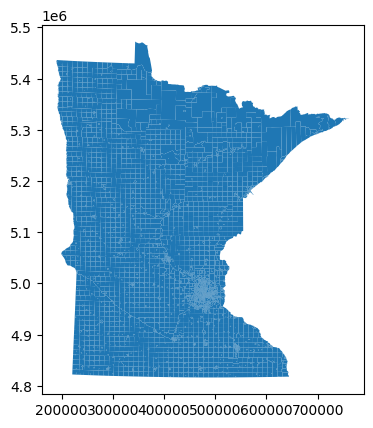

In [52]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()